In [1]:
import numpy as np
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score,  train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from __future__ import division
import matplotlib.pyplot as plt

C:\Users\User\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = load_boston()
X = data.data
y = data.target

In [4]:
X_train = X[:int(X.shape[0] * 0.75)][:]
X_test = X[int(X.shape[0] * 0.75):][:]
y_train = y[:int(X.shape[0] * 0.75)]
y_test = y[int(X.shape[0] * 0.75):]

In [5]:
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(379L, 13L)
(127L, 13L)
(379L,)
(127L,)


In [6]:
print data.DESCR

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [7]:
def gbm_predict(X, base_algorithms_list, coefficients_list):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]

def construct_boost_stack(X_train, y_train, coefficients_list):
    boost_stack = []
    a = y_train
    for step in coefficients_list:
        estimator = DecisionTreeRegressor(max_depth=5, random_state=42)
        estimator.fit(X_train, a)
        boost_stack.append(estimator)
        a = -(gbm_predict(X_train, boost_stack, coefficients_list)-y_train) 
    return boost_stack

In [8]:
coeffs = np.array([0.9] * 50)
boost_stack50 = construct_boost_stack(X_train, y_train, coeffs)

MSE = mean_squared_error(y_test, gbm_predict(X_test, boost_stack50, coeffs))
RMSE = MSE ** 0.5

with open('ans2.txt', 'w') as foutput:
    foutput.write(str(RMSE))

In [9]:
coeffs = np.array(list(0.9 / (1.0 + i) for i in xrange(50)))
boost_stack50_biased = construct_boost_stack(X_train, y_train, coeffs)

MSE = mean_squared_error(y_test, gbm_predict(X_test, boost_stack50_biased, coeffs))
RMSE = MSE ** 0.5

with open('ans3.txt', 'w') as foutput:
    foutput.write(str(RMSE))

In [10]:
trees = np.arange(1, 500, 50)
depths = np.arange(1, 100)
RMSE_trees = []
RMSE_depths = []

for tree in trees:
    estimator = xgb.XGBRegressor(max_depth=2, learning_rate=1, n_estimators=tree)
    estimator.fit(X_train, y_train)
    RMSE = mean_squared_error(y_test, estimator.predict(X_test)) ** 0.5
    RMSE_trees.append(RMSE)   
    
for depth in depths:
    estimator = xgb.XGBRegressor(max_depth=depth, learning_rate=1, n_estimators=50)
    estimator.fit(X_train, y_train)
    RMSE = mean_squared_error(y_test, estimator.predict(X_test)) ** 0.5
    RMSE_depths.append(RMSE)

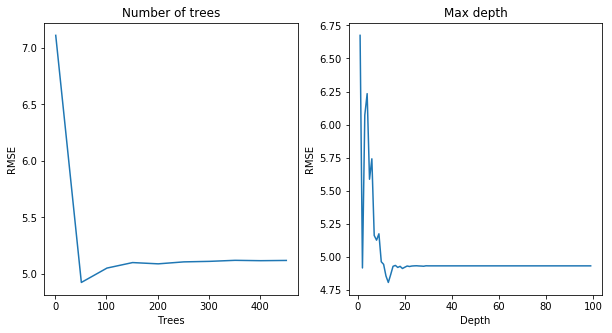

In [11]:
plt.figure(figsize(10,5))

plt.subplot(1,2,1)
plt.title('Number of trees')
plt.xlabel('Trees')
plt.ylabel('RMSE')
plt.plot(trees, RMSE_trees)

plt.subplot(1,2,2)
plt.title('Max depth')
plt.xlabel('Depth')
plt.ylabel('RMSE')
plt.plot(depths, RMSE_depths)

In [12]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
RMSE = mean_squared_error(y_test, linreg.predict(X_test)) ** 0.5
with open('ans5.txt', 'w') as foutput:
    foutput.write(str(RMSE))